### Tolic's notes
[twitter sentiment description](http://help.sentiment140.com/for-students)

# ------------------------------------------

# Скачаем датасет данных с Twitter Sentiment

In [ ]:
! mkdir -p /home/jovyan/data
! mkdir -p /home/jovyan/models
! echo Dirs created

In [ ]:
! wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip -O /home/jovyan/data/sentiment.zip

In [ ]:
! cd /home/jovyan/data && unzip sentiment.zip

In [ ]:
! ls -la /home/jovyan/data

In [ ]:
! head -n 5 /home/jovyan/data/training.1600000.processed.noemoticon.csv

# Читаем датасет с помощью Spark

In [53]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('twitter-sentiment').getOrCreate()

print("Spark context started")

Spark context started


In [54]:
from pyspark.sql.types import StructType, StructField, IntegerType, LongType, StringType

schema = StructType([
    StructField("target", IntegerType(), True),
    StructField("id", LongType(), True),
    StructField("raw_timestamp", StringType(), True),
    StructField("query_status", StringType(), True),
    StructField("author", StringType(), True),
    StructField("tweet", StringType(), True)
])
    
data_path = "/home/jovyan/data/training.1600000.processed.noemoticon.csv"

raw_sentiment = spark.read.csv(data_path,header=False,schema=schema) \
    .selectExpr("(case when target=4 then 1 else 0 end) as target","tweet")

raw_sentiment.groupBy("target").count().show()

+------+------+
|target| count|
+------+------+
|     1|800000|
|     0|800000|
+------+------+



In [55]:
!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [56]:
raw_sentiment_sample = raw_sentiment.sample(fraction=0.01,withReplacement=False,seed=42).toPandas()
X, y = raw_sentiment_sample["tweet"], raw_sentiment_sample["target"]

print("Dataset size is: %i" % X.size)

Dataset size is: 16086


In [57]:
raw_sentiment_sample.head()

,target,tweet
0,0,Need a hug
1,0,@mangaaa I hope they will increase the capacit...
2,0,@mercedesashley Damn! The grind is inspiration...
3,0,"Just got my presentation done, 23 slides done...."
4,0,"http://is.gd/r8Zf, http://is.gd/r8Zy, and ht..."


In [59]:
from sklearn.model_selection import GridSearchCV
from time import time
from pprint import pprint

from sentiment_model import pipeline, parameters

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, cv=3,
                               n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X, y)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['tfidf', 'clf']
parameters:
{'clf__max_depth': (5, 8),
 'clf__n_estimators': (40, 60, 100),
 'tfidf__max_df': (0.5, 0.75, 1.0)}
Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:  2.1min finished


done in 131.245s

Best score: 0.662
Best parameters set:
	clf__max_depth: 8
	clf__n_estimators: 100
	tfidf__max_df: 1.0


In [62]:
import pickle as pkl

def save_model(model,model_path):
    with open(model_path,'wb') as buffer:
        pkl.dump(model,buffer)

def read_model(model_path):
    with open(model_path,'rb') as buffer:
        return pkl.load(buffer)

model_path = "/home/jovyan/models/tweet_sentiment.mdl"
save_model(grid_search.best_estimator_,model_path)

In [63]:
model_object = read_model(model_path)
model_object

Pipeline(memory=None,
         steps=[('tfidf',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 1), norm='l2',
                                 preprocessor=<function preprocessor at 0x7f0116d2ac80>,
                                 smooth_idf=True, stop_words=None,
                                 strip_accents=None,...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=8,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,

In [65]:
a = model_object.predict_proba(X)

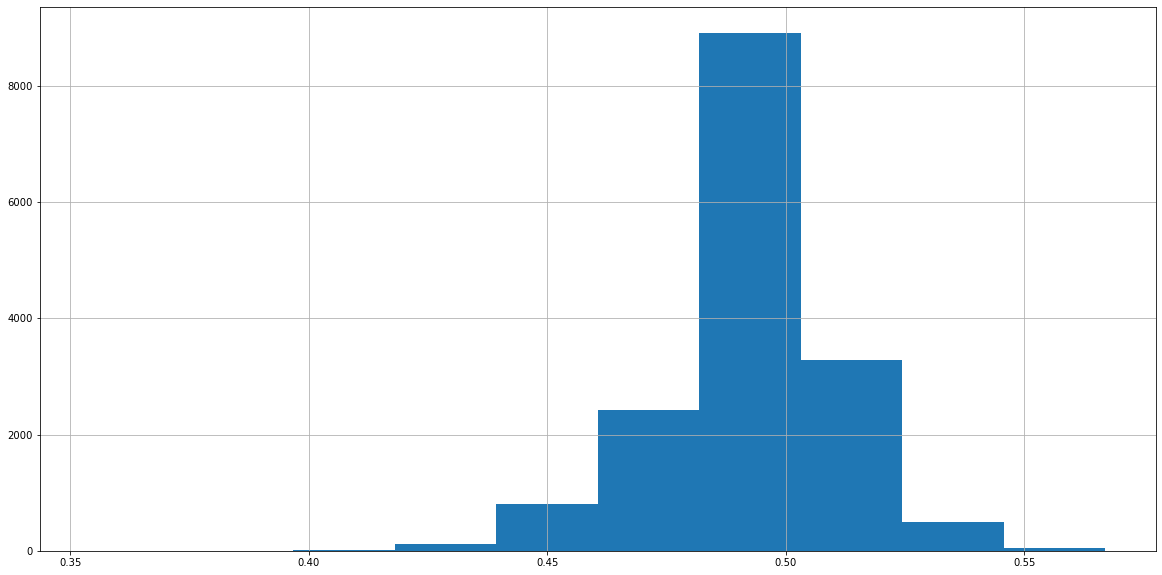

In [92]:
%matplotlib inline
import pandas as pd

pd.Series(model_object.predict_proba(X)[:,1]).hist(figsize=(20,10))

In [93]:
spark.stop()

# Tolic's additional experiments
# ------------------------------------------------------

In [ ]:
print(X)
print("-----------------------------------------------------")
print(y)

In [ ]:
toldf = spark.read.csv(data_path,header=False,schema=schema)
#toldf.where("tweet like '%Need%a%hug%'").select("id", "tweet").show(20,150)
toldf = toldf.selectExpr("(case when target=4 then 1 else 0 end) as target","id","raw_timestamp","query_status","author","tweet")
toldf_sample = toldf.sample(fraction=0.01,withReplacement=False,seed=42).toPandas()
toldf_sample.head()

In [61]:
best_parameters?

Type:        dict
String form: {'memory': None, 'steps': [('tfidf', TfidfVectorizer(analyzer='word', binary=False, decode_error= <...>  'clf__oob_score': False, 'clf__random_state': None, 'clf__verbose': 0, 'clf__warm_start': False}
Length:      43
Docstring:  
dict() -> new empty dictionary
dict(mapping) -> new dictionary initialized from a mapping object's
    (key, value) pairs
dict(iterable) -> new dictionary initialized as if via:
    d = {}
    for k, v in iterable:
        d[k] = v
dict(**kwargs) -> new dictionary initialized with the name=value pairs
    in the keyword argument list.  For example:  dict(one=1, two=2)


In [64]:
X

0                                              Need a hug 
1        @mangaaa I hope they will increase the capacit...
2        @mercedesashley Damn! The grind is inspiration...
3        Just got my presentation done, 23 slides done....
4        http://is.gd/r8Zf,  http://is.gd/r8Zy, and  ht...
                               ...                        
16081                            TVMA is now on Twitter!! 
16082                                      to be with you 
16083    loves visitors so if you are goin to the Aeros...
16084    @BrunoFigueiredo @ppinheiro76 @pedrocs Top Gea...
16085                 @Bruno108 I would like some please! 
Name: tweet, Length: 16086, dtype: object

In [74]:
print(X.size)
print(a.shape)

16086
(16086, 2)


In [91]:
def predict01(ind):
    if a[ind,0]>a[ind,1]:
        return 0
    else:
        return 1

qnty = 0
for i in range(10,a.shape[0]):
    pre = predict01(i)
    if pre != y[i]:
        qnty = qnty+1
print(qnty)
    #print(X[i])
    #print("\t", "origin: ",y[i], "\t", "predict: ",)

4653


In [88]:
a.shape[0]

16086